In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import product

In [2]:

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


nu = 0.01 / np.pi  # viscosity
x_min, x_max = -1.0, 1.0
t_min, t_max = 0.0, 1.0

In [3]:
def generate_data(n_points=10000):
    
    x_f = torch.FloatTensor(n_points, 1).uniform_(x_min, x_max).to(device)
    t_f = torch.FloatTensor(n_points, 1).uniform_(t_min, t_max).to(device)

    
    n0 = n_points // 10
    x0 = torch.linspace(x_min, x_max, n0).view(-1, 1).to(device)
    t0 = torch.zeros_like(x0).to(device)
    u0 = -torch.sin(np.pi * x0)

    
    nb = n_points // 10
    t_b = torch.linspace(t_min, t_max, nb).view(-1, 1).to(device)
    x_b_left = x_min * torch.ones_like(t_b).to(device)
    x_b_right = x_max * torch.ones_like(t_b).to(device)
    
    return x_f, t_f, x0, t0, u0, x_b_left, t_b, x_b_right

In [4]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        num_layers = len(layers)
        
        for i in range(num_layers - 1):
            linear = nn.Linear(layers[i], layers[i + 1])
            nn.init.xavier_normal_(linear.weight)
            nn.init.zeros_(linear.bias)
            self.layers.append(linear)
            
        self.num_layers = num_layers

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            # Use GELU for all hidden layers except the last one which uses Tanh.
            if i == len(self.layers) - 2:
                x = torch.tanh(x)
            else:
                x = torch.nn.functional.gelu(x)
        return self.layers[-1](x)

In [5]:
def compute_derivatives(net, x, t):
    X = torch.cat([x, t], dim=1).requires_grad_(True)
    u = net(X)
    grad_u = autograd.grad(u, X, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_x, u_t = grad_u[:, 0:1], grad_u[:, 1:2]
    u_xx = autograd.grad(u_x, X, torch.ones_like(u_x), create_graph=True, retain_graph=True)[0][:, 0:1]
    return u, u_x, u_t, u_xx

def loss_function(net, x_f, t_f, x0, t0, u0, x_b_left, t_b, x_b_right,
                  nu, weight_f=1.0, weight_ic=5.0, weight_bc=5.0):

    x_f_temp = x_f.detach().requires_grad_(True)
    t_f_temp = t_f.detach().requires_grad_(True)
    
   
    u, u_x, u_t, u_xx = compute_derivatives(net, x_f_temp, t_f_temp)
    f_pred = u_t + u * u_x - nu * u_xx
    loss_f = torch.mean(f_pred ** 2)
    
    
    u_pred_0 = net(torch.cat([x0, t0], dim=1))
    loss_ic = torch.mean((u_pred_0 - u0) ** 2)
    
    
    u_pred_left = net(torch.cat([x_b_left, t_b], dim=1))
    u_pred_right = net(torch.cat([x_b_right, t_b], dim=1))
    loss_bc = torch.mean(u_pred_left ** 2) + torch.mean(u_pred_right ** 2)
    
    total_loss = weight_f * loss_f + weight_ic * loss_ic + weight_bc * loss_bc
    return total_loss, loss_f, loss_ic, loss_bc


In [6]:

def train_hybrid(net, data, adam_epochs, adam_lr, lbfgs_epochs, lbfgs_lr,
                 weight_f, weight_ic, weight_bc, print_every=500):
    x_f, t_f, x0, t0, u0, x_b_left, t_b, x_b_right = data
    loss_history = []
    start_time = datetime.now()
    
    # Phase 1: Adam optimizer
    print("Phase 1: Training with Adam optimizer")
    optimizer_adam = optim.Adam(net.parameters(), lr=adam_lr)
    for epoch in range(adam_epochs):
        optimizer_adam.zero_grad()
        loss, loss_f, loss_ic, loss_bc = loss_function(
            net, x_f, t_f, x0, t0, u0,
            x_b_left, t_b, x_b_right, nu,
            weight_f, weight_ic, weight_bc
        )
        loss.backward()
        optimizer_adam.step()
        loss_history.append(loss.item())
        
        if epoch % print_every == 0 or epoch == adam_epochs - 1:
            elapsed = datetime.now() - start_time
            print(f'Adam Epoch {epoch:05d} | Time: {elapsed} | '
                  f'Loss: {loss.item():.4e} | '
                  f'PDE: {loss_f.item():.4e} | '
                  f'IC: {loss_ic.item():.4e} | '
                  f'BC: {loss_bc.item():.4e}')
    
    adam_transition = len(loss_history)
    
    # Phase 2: L-BFGS optimizer
    print("\nPhase 2: Refinement with L-BFGS optimizer")
    optimizer_lbfgs = optim.LBFGS(net.parameters(),
                                  lr=lbfgs_lr,
                                  max_iter=20,
                                  max_eval=25,
                                  history_size=50,
                                  line_search_fn='strong_wolfe')
    
    def closure():
        optimizer_lbfgs.zero_grad()
        loss, _, _, _ = loss_function(
            net, x_f, t_f, x0, t0, u0,
            x_b_left, t_b, x_b_right, nu,
            weight_f, weight_ic, weight_bc
        )
        loss.backward()
        return loss
    
    for epoch in range(lbfgs_epochs):
        loss = optimizer_lbfgs.step(closure)
        loss_history.append(loss.item())
        if epoch % print_every == 0 or epoch == lbfgs_epochs - 1:
            print(f'L-BFGS Epoch {epoch:04d} | Loss: {loss.item():.4e}')
    
    return net, loss_history, adam_transition


def evaluate_model(net, data, weight_f, weight_ic, weight_bc):
    
    net.eval()
   
    loss, loss_f, loss_ic, loss_bc = loss_function(
        net, *data, nu, weight_f, weight_ic, weight_bc
    )
    net.train()
    return loss.item()

In [7]:
def visualize_solution(net, nx=100, nt=100):
    x = torch.linspace(x_min, x_max, nx).view(-1, 1).to(device)
    t = torch.linspace(t_min, t_max, nt).view(-1, 1).to(device)
    
    X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')  # Meshgrid for 2D representation
    X_flat = X.reshape(-1, 1)
    T_flat = T.reshape(-1, 1)
    input_pts = torch.cat([X_flat, T_flat], dim=1)
    
    u_pred = net(input_pts).cpu().detach().numpy()
    u_grid = u_pred.reshape(nx, nt)
    
    plt.figure(figsize=(12, 8))
    plt.contourf(T.cpu().numpy(), X.cpu().numpy(), u_grid, 50, cmap='rainbow')  
    plt.colorbar(label='u(x,t)')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(f'PINN Solution to Burgers Equation (ν={nu:.4f})')
    plt.show()
    
    # Snapshots at selected time points
    t_snapshots = [0.0, 0.25, 0.5, 0.75, 1.0]
    plt.figure(figsize=(15, 7))
    for i, t_val in enumerate(t_snapshots):
        t_idx = int(t_val * (nt - 1))
        plt.subplot(1, len(t_snapshots), i + 1)
        plt.plot(x.cpu().numpy(), u_grid[:, t_idx])
        plt.ylim([-1.1, 1.1])
        plt.grid(True)
        plt.title(f't = {t_val:.2f}')
        if i == 0:
            plt.ylabel('u(x,t)')
        plt.xlabel('x')
    plt.tight_layout()
    plt.show()

In [8]:

def grid_search(train_data, val_data, hyperparams, save_dir='saved_models'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    best_val_loss = np.inf
    best_config = None
    best_state = None
    
    for (arch, wf, wic, wbc, adam_lr, adam_epochs, lbfgs_lr, lbfgs_epochs) in product(
            hyperparams['architecture'],
            hyperparams['weight_f'],
            hyperparams['weight_ic'],
            hyperparams['weight_bc'],
            hyperparams['adam_lr'],
            hyperparams['adam_epochs'],
            hyperparams['lbfgs_lr'],
            hyperparams['lbfgs_epochs']):
        
        print("\n" + "=" * 80)
        print(f"Training with configuration:\n"
              f"Architecture: {arch}\n"
              f"Loss Weights -> PDE: {wf}, IC: {wic}, BC: {wbc}\n"
              f"Adam: lr={adam_lr}, epochs={adam_epochs} | LBFGS: lr={lbfgs_lr}, epochs={lbfgs_epochs}")
        
        net = PINN(arch).to(device)
        trained_net, loss_history, adam_transition = train_hybrid(
            net, train_data,
            adam_epochs=adam_epochs,
            adam_lr=adam_lr,
            lbfgs_epochs=lbfgs_epochs,
            lbfgs_lr=lbfgs_lr,
            weight_f=wf,
            weight_ic=wic,
            weight_bc=wbc,
            print_every=adam_epochs // 10 if adam_epochs >= 10 else 1
        )
        val_loss = evaluate_model(trained_net, val_data, wf, wic, wbc)
        print(f"Validation Loss: {val_loss:.4e}")
        
        config_name = (f"arch{'-'.join(map(str, arch))}_wf{wf}_wic{wic}_wbc{wbc}_"
                       f"adam{adam_lr}_{adam_epochs}_lbfgs{lbfgs_lr}_{lbfgs_epochs}")
        model_path = os.path.join(save_dir, f"{config_name}.pt")
        torch.save(trained_net.state_dict(), model_path)
        print(f"Model saved at: {model_path}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_config = {
                'architecture': arch,
                'weight_f': wf,
                'weight_ic': wic,
                'weight_bc': wbc,
                'adam_lr': adam_lr,
                'adam_epochs': adam_epochs,
                'lbfgs_lr': lbfgs_lr,
                'lbfgs_epochs': lbfgs_epochs,
                'model_path': model_path
            }
            best_state = trained_net.state_dict()
    
    print("\n" + "=" * 80)
    print("Grid Search Complete!")
    print(f"Best Validation Loss: {best_val_loss:.4e}")
    print("Best Hyperparameters:")
    for key, value in best_config.items():
        print(f"  {key}: {value}")
    
    return best_config, best_state

Using device: cuda
Burgers equation with viscosity ν = 0.0032

Training with configuration:
Architecture: [2, 16, 32, 16, 1]
Loss Weights -> PDE: 1.0, IC: 5.0, BC: 5.0
Adam: lr=0.005, epochs=5000 | LBFGS: lr=0.01, epochs=100
Phase 1: Training with Adam optimizer


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Adam Epoch 00000 | Time: 0:00:04.065443 | Loss: 2.9739e+00 | PDE: 4.2912e-03 | IC: 5.7838e-01 | BC: 1.5532e-02
Adam Epoch 00500 | Time: 0:00:07.648842 | Loss: 2.8190e-01 | PDE: 2.0344e-01 | IC: 1.5262e-02 | BC: 4.3054e-04
Adam Epoch 01000 | Time: 0:00:11.237168 | Loss: 1.7745e-01 | PDE: 1.3601e-01 | IC: 8.2018e-03 | BC: 8.7756e-05
Adam Epoch 01500 | Time: 0:00:14.760237 | Loss: 1.5067e-01 | PDE: 1.1759e-01 | IC: 5.8268e-03 | BC: 7.8860e-04
Adam Epoch 02000 | Time: 0:00:18.282228 | Loss: 8.1074e-02 | PDE: 5.3098e-02 | IC: 4.4391e-03 | BC: 1.1562e-03
Adam Epoch 02500 | Time: 0:00:21.864866 | Loss: 4.3213e-02 | PDE: 3.4529e-02 | IC: 1.4574e-03 | BC: 2.7945e-04
Adam Epoch 03000 | Time: 0:00:25.437825 | Loss: 2.4805e-02 | PDE: 2.1331e-02 | IC: 6.7809e-04 | BC: 1.6856e-05
Adam Epoch 03500 | Time: 0:00:29.223363 | Loss: 2.1947e-02 | PDE: 1.7961e-02 | IC: 7.2872e-04 | BC: 6.8552e-05
Adam Epoch 04000 | Time: 0:00:32.780978 | Loss: 1.8753e-02 | PDE: 1.6199e-02 | IC: 5.0330e-04 | BC: 7.5721e-06
A

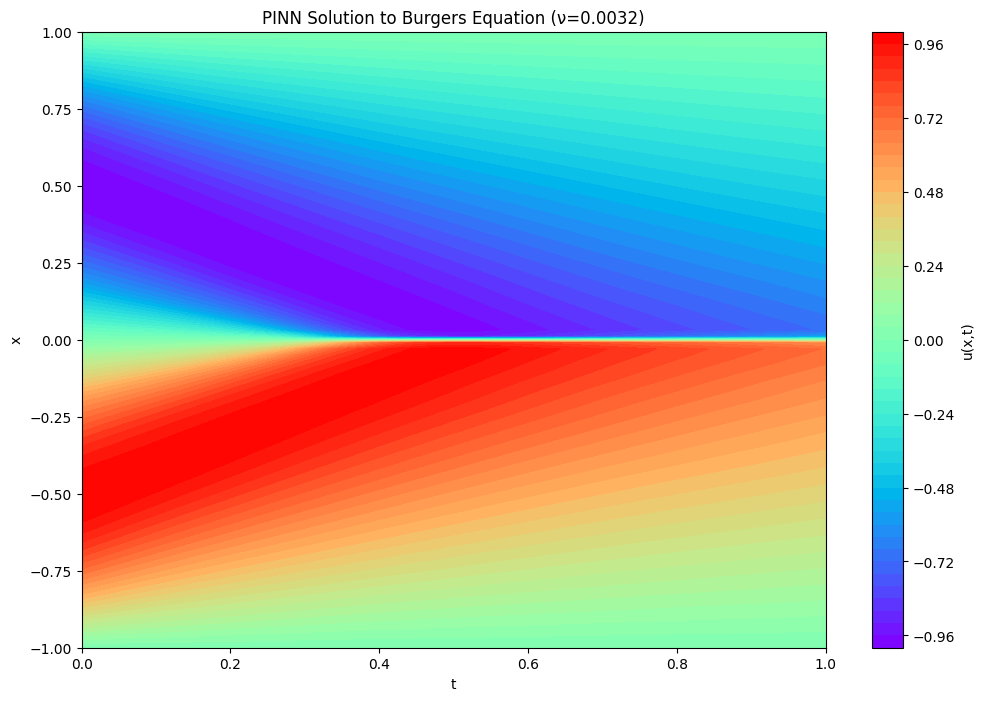

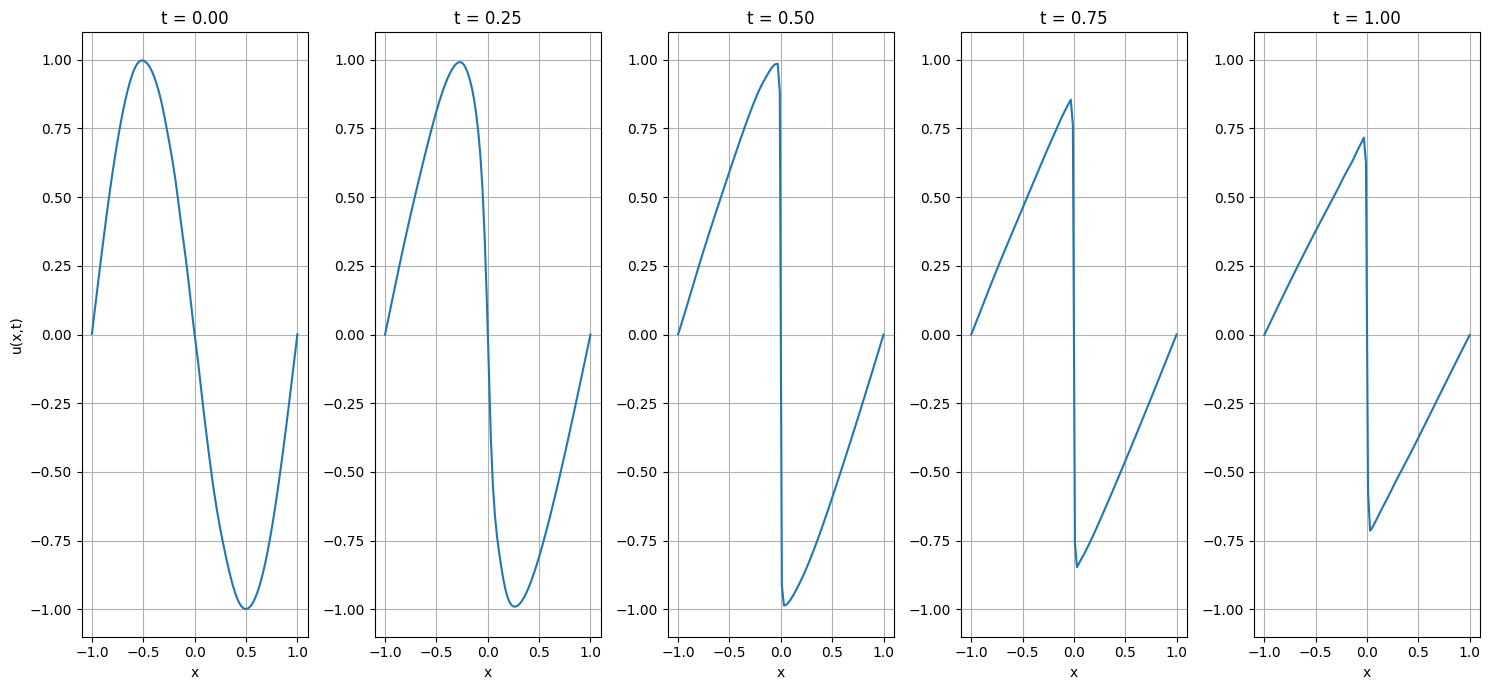

In [9]:
if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Burgers equation with viscosity ν = {nu:.4f}")
    
    train_data = generate_data(n_points=10000)
    val_data = generate_data(n_points=2000)
    
    hyperparams = {
        'architecture': [
            [2, 16, 32, 16, 1],
            [2, 16, 64, 16, 1],
            [2, 16, 32, 8, 1]
        ],
        'weight_f': [1.0, 1.25, 1.5],
        'weight_ic': [5.0],
        'weight_bc': [5.0],
        'adam_lr': [0.005, 0.001],
        'adam_epochs': [5000, 10000],
        'lbfgs_lr': [0.01],
        'lbfgs_epochs': [100]
    }
    
    best_config, best_state = grid_search(train_data, val_data, hyperparams, save_dir='saved_models')
    
    best_arch = best_config['architecture']
    best_model = PINN(best_arch).to(device)
    best_model.load_state_dict(best_state)
    
    visualize_solution(best_model)